In [1]:
from data_utils import *
from data_utils import test_distribution
from model_utils import *
import joblib

/home/amakelov/workspace/current/conda_envs/serimats/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = get_model()

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


# Setup

In [17]:
POSITION_SUBSPACE_PATH = 'subspaces/state_dict_head_outputs_1dim_922test.pt'
rotation = RotationMatrix.load_rotation_old(path=POSITION_SUBSPACE_PATH, n=768)
rotation.requires_grad_(False)
POSITION_DIRECTION = rotation.R.weight.data[:, 0].detach().cuda()
resid_node = Node('resid_post', layer=8, seq_pos=-1)
mlp_node = Node('post', layer=8, seq_pos=-1)
resid_node_mid = Node('resid_mid', layer=8, seq_pos=-1)
NAME_MOVERS = [(9, 6), (9, 9), (10, 0)]
BACKUP_NAME_MOVERS = [(9, 0), (9, 7), (10, 1), (10, 2), (10, 6), (10, 10), (11, 2), (11, 9)]

# das directions
das_mlp8 = torch.Tensor(joblib.load(filename='das_mlp8.joblib')).cuda()
das_resid = POSITION_DIRECTION
das_resid_mid = torch.Tensor(joblib.load(filename='das_resid_mid.joblib')).cuda()

W_out = model.W_out[8]
# Q is of shape (3072, 768), and the columns of Q are an orthonormal basis
# for the rowspace of W_out
Q, _ = torch.linalg.qr(W_out) 
das_mlp8_row = das_mlp8 @ Q @ Q.T
das_mlp8_null = das_mlp8 - das_mlp8_row
das_mlp8_row_unit = das_mlp8_row / das_mlp8_row.norm()
das_mlp8_null_unit = das_mlp8_null / das_mlp8_null.norm()

# gradients
head_gs = joblib.load(filename='name_mover_gradients.joblib')
head_gs = [torch.Tensor(g).cuda() for g in head_gs]
summed_gradient = torch.Tensor(joblib.load(filename='summed_gradient.joblib')).cuda()

# mean difference between ABB and BAB prompts
v_mean = torch.Tensor(joblib.load(filename='v_mean.joblib')).cuda()

### reproducible datasets to use for analysis
random.seed(42)
TEST_DATASET = test_distribution.sample_das(
        model=model,
        base_patterns=['ABB',],
        source_patterns=['BAB'],
        labels='position',
        samples_per_combination=1_000,
    )

PATCHING_DATASET = test_distribution.sample_das(
        model=model,
        base_patterns=['ABB',],
        source_patterns=['BAB'],
        labels='position',
        samples_per_combination=1_000,
    ) + test_distribution.sample_das(
        model=model,
        base_patterns=['BAB',],
        source_patterns=['ABB'],
        labels='position',
        samples_per_combination=1_000,
    )

TRAIN_DATASET = train_distribution.sample_das(
        model=model,
        base_patterns=['ABB',],
        source_patterns=['BAB'],
        labels='position',
        samples_per_combination=1_000,
)

# Experiments

## cosine similarity between DAS direction in residual stream and gradient of name mover heads

In [7]:
das_resid @ summed_gradient
torch.cosine_similarity(das_resid, summed_gradient, dim=0)

tensor(-0.7823, device='cuda:0')

## Decomposing DAS-resid and gradient along name mover queries

In [5]:
def decompose_resid_along_namemovers(v: Tensor):
    WQs = [model.W_Q[layer, head] for layer, head in NAME_MOVERS] # each of shape (d_model, d_head)
    WQ_concat = torch.cat(WQs, dim=1)
    Q, _ = torch.linalg.qr(WQ_concat)
    rowspace_component = v @ Q @ Q.T
    nullspace_component = v - rowspace_component
    return rowspace_component, nullspace_component

das_resid_row, das_resid_null = decompose_resid_along_namemovers(das_resid)
grad_row, grad_null = decompose_resid_along_namemovers(summed_gradient)

In [9]:
# both directions are significantly in the rowspace of the namemovers
print(f'norm of das_resid_row: {das_resid_row.norm()}')
print(f'norm of grad_row: {grad_row.norm()}')

norm of das_resid_row: 0.9101414084434509
norm of grad_row: 0.98272705078125


## Projections of prompts on the DAS resid and gradient directions

In [10]:
def remove_all_hooks(model):
    for _, submodule in model.named_modules():
        submodule._forward_hooks.clear()

def get_patching_acc_and_ld(patching_dataset: PatchingDataset,
                            patcher: Patcher) -> Tuple[float, float]:
    """
    Given a patcher, return the interchange accuracy and the logit difference on
    the base dataset.
    """
    patched_predictions = []
    base_answer_logits_patched = []
    for batch_ds in tqdm(patching_dataset.batches(batch_size=100, shuffle=False), total=len(patching_dataset) // 100):
        _, _, _, logits_patched = patcher.run_patching(
            model=model,
            P_base=batch_ds.base.tokens,
            P_source=batch_ds.source.tokens,
            answer_tokens_base=batch_ds.base.answer_tokens,
            answer_tokens_source=batch_ds.source.answer_tokens,
            patched_answer_tokens=batch_ds.patched_answer_tokens,
            return_full_patched_logits=True,
        )
        patched_predictions.append(logits_patched.argmax(dim=-1))
        base_answer_logits_patched.append(logits_patched.gather(dim=1, index=batch_ds.base.answer_tokens.cuda()))
    patched_predictions = torch.cat(patched_predictions)
    interchange_accuracy = (patched_predictions == patching_dataset.patched_answer_tokens[:, 0].cuda()).float().mean().item()
    base_answer_logits_patched = torch.cat(base_answer_logits_patched)
    base_answers_logit_diff = (base_answer_logits_patched[:, 0] - base_answer_logits_patched[:, 1]).mean().item()
    return interchange_accuracy, base_answers_logit_diff

def get_resid_projections(v: Tensor, patching_dataset: PatchingDataset):
    node = Node('resid_post', layer=8, seq_pos=-1)
    prompts = np.concatenate([patching_dataset.base.prompts, patching_dataset.source.prompts], axis=0)
    A = run_with_cache(prompts=prompts, nodes=[node], model=model, batch_size=100)[0]
    projs = einsum("batch dim, dim -> batch", A, v)
    num_examples = len(patching_dataset.base.prompts)
    return pd.DataFrame({
        'pattern': ['ABB'] * num_examples + ['BAB'] * num_examples,
        'projection': projs.cpu().numpy(),
    })

In [11]:
gradient_projs = get_resid_projections(patching_dataset=TEST_DATASET, v=summed_gradient)
das_resid_projs = get_resid_projections(patching_dataset=TEST_DATASET, v=das_resid)

100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


In [12]:
gradient_projs['direction'] = 'grad'
das_resid_projs['direction'] = 'das'
resid_projs_df = pd.concat([gradient_projs, das_resid_projs], ignore_index=True)

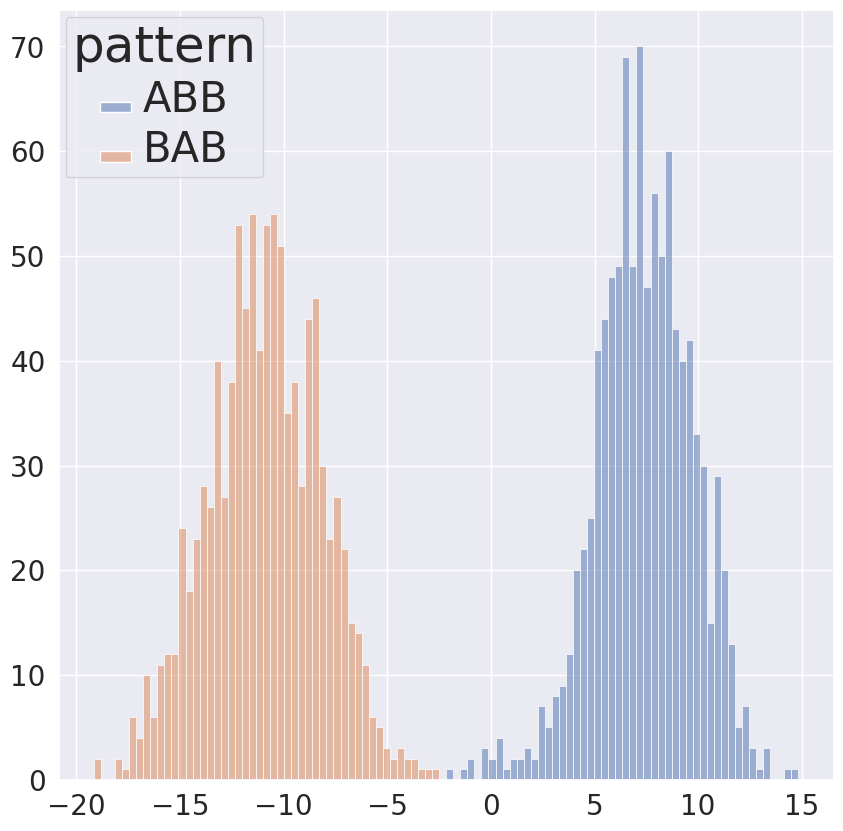

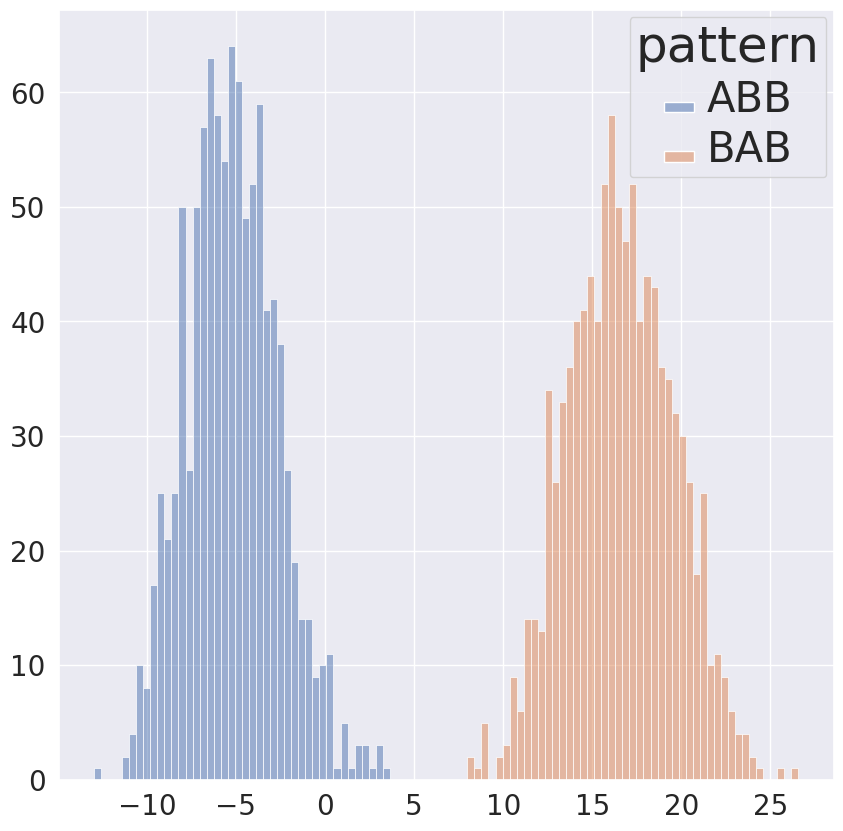

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

for direction in ('grad', 'das'):
    # make a high-res plot
    plt.figure(figsize=(10, 10))
    ax = sns.histplot(
        data=resid_projs_df.query(f'direction == "{direction}"'),
        x='projection',
        hue='pattern',
        # do not stack, but overlap them
        multiple='layer',
        bins=100,
        stat='count',
        common_norm=False,
        element='bars',
        fill=True,
        alpha=0.5,
        legend=True,
    )
    # plt.legend(title='Pattern', title_fontsize=24, fontsize=20,)
    # set the x-axis limits
    # increase title font size
    # remove the labels of the x and y axes
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    # increase font of the tikz on the axes
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.setp(ax.get_legend().get_texts(), fontsize='30') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
    plt.savefig(f'figures/resid_projs_{direction}.pdf', format='pdf')
    plt.show()

## Sanity check: can we predict S or IO names from projections on DAS resid?
If this direction encodes only name information, there should be no signal there
about names in the sentence.

In [20]:
das_resid_projs_df = get_resid_projections(patching_dataset=TRAIN_DATASET, v=das_resid)
das_resid_projs = das_resid_projs_df['projection'].values

100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


In [22]:
### check if we can predict the S or IO name from the projections on DAS resid (we can't)
io_names = [p.io_name for p in TRAIN_DATASET.base.prompts] + [p.io_name for p in TRAIN_DATASET.source.prompts]
s_names = [p.s_name for p in TRAIN_DATASET.base.prompts] + [p.s_name for p in TRAIN_DATASET.source.prompts]
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = das_resid_projs.reshape(-1, 1)
for y in (io_names, s_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, )
    clf = LogisticRegression(random_state=0, max_iter=1_000).fit(X_train, y_train)
    print(f'Train acc: {clf.score(X_train, y_train)}')
    print(f'Test acc: {clf.score(X_test, y_test)}')

Train acc: 0.01875
Test acc: 0.005
Train acc: 0.024375
Test acc: 0.0075


## Code for Table 1

In [22]:
def compute_patch_metrics(patching_dataset: PatchingDataset,):
    """
    Compute the following quantities:
        - the components of das_mlp8 along the nullspace and rowspace of W_out,
          and their norms;
        - the logit difference when we only patch the rowspace component
        - a histogram showing ABB vs BAB prompts on the nullspace component
        - a histogram showing ABB vs BAB prompts on the rowspace component
        - the cosine similarity between das_mlp8 @ W_out and true_subspace
        - a histogram of ABB vs BAB prompts on true_subspace
        - a histogram of ABB vs BAB prompts on das_mlp8 @ W_out 
        - a histogram of ABB vs BAB after patching along das_mlp8
        
        - a table of the logit differences and interchange accuracies for:
            - the MLP8 direction
            - the rowspace component of the MLP8 direction only
            - the resid direction
    """
    print(f'norm of das_mlp8_row: {das_mlp8_row.norm()}')
    print(f'norm of das_mlp8_null: {das_mlp8_null.norm()}')
    print(f'Check that das_mlp8_row and das_mlp8_null are orthogonal: {das_mlp8_row @ das_mlp8_null}')
    print(f'Check that das_mlp8_null is in the nullspace of W_out: '
          f'{torch.allclose(das_mlp8_null @ W_out, torch.zeros(768).cuda(), atol=1e-5)}')
        
    aggregate_metrics_rows = []
    
    ############################################################################ 
    ### compute clean predictions
    ############################################################################ 
    clean_predictions = run_with_hooks(prompts=patching_dataset.base.prompts, 
                                  hooks=[], model=model, batch_size=100, 
                                  answer_tokens=patching_dataset.base.answer_tokens.cuda(),
                                  return_predictions=True)
    clean_logits = run_with_hooks(prompts=patching_dataset.base.prompts, hooks=[], model=model, batch_size=100,
                    answer_tokens=patching_dataset.base.answer_tokens.cuda())
    clean_accuracy = (clean_predictions == patching_dataset.base.answer_tokens[:, 0].cuda()).float().mean().item()
    clean_logit_diff = (clean_logits[:, 0] - clean_logits[:, 1]).mean().item()
    print(f'clean accuracy: {clean_accuracy}')
    aggregate_metrics_rows.append({
        'intervention': 'clean',
        'accuracy': 0.0,
        'logit_diff': clean_logit_diff,
    })

    ############################################################################ 
    ### intervention: full resid replace
    ############################################################################ 
    full_resid_patcher = Patcher(
        nodes=[resid_node],
        patch_impl=Full(),
    )
    patched_acc_resid_full, logit_diff_resid_full = get_patching_acc_and_ld(
        patcher=full_resid_patcher,
        patching_dataset=patching_dataset,
    )
    aggregate_metrics_rows.append({
        'intervention': 'full resid_post.8 patch',
        'accuracy': patched_acc_resid_full,
        'logit_diff': logit_diff_resid_full,
    })

    ############################################################################ 
    ### compute resid predictions and logit diff
    ############################################################################ 
    resid_patcher = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=das_resid),
    )
    patched_accuracy_resid, logit_diff_resid = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=resid_patcher,
    )
    aggregate_metrics_rows.append({
        'intervention': 'DAS resid_post.8',
        'accuracy': patched_accuracy_resid,
        'logit_diff': logit_diff_resid,
    })
    
    resid_row, resid_null = decompose_resid_along_namemovers(v=das_resid)
    resid_row_unit = resid_row / resid_row.norm()
    resid_patcher_rowspace = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=resid_row_unit),
    )
    patched_accuracy_resid_row, logit_diff_resid_row = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=resid_patcher_rowspace,
    )
    aggregate_metrics_rows.append({
        'intervention': 'DAS resid_post.8 along name movers',
        'accuracy': patched_accuracy_resid_row,
        'logit_diff': logit_diff_resid_row,
    })

    resid_null_unit = resid_null / resid_null.norm()
    resid_patcher_nullspace = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=resid_null_unit),
    )
    patched_accuracy_resid_null, logit_diff_resid_null = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=resid_patcher_nullspace,
    )
    aggregate_metrics_rows.append({
        'intervention': 'DAS resid_post.8 along nullspace',
        'accuracy': patched_accuracy_resid_null,
        'logit_diff': logit_diff_resid_null,
    })

    ############################################################################ 
    ### compute grad predictions and logit diff
    ############################################################################ 
    grad_patcher = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=summed_gradient),
    )
    patched_accuracy_grad, logit_diff_grad = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=grad_patcher,
    )
    aggregate_metrics_rows.append({
        'intervention': 'grad resid_post.8',
        'accuracy': patched_accuracy_grad,
        'logit_diff': logit_diff_grad,
    })
    
    grad_row, grad_null = decompose_resid_along_namemovers(v=summed_gradient)
    grad_row_unit = grad_row / grad_row.norm()
    grad_patcher_rowspace = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=grad_row_unit),
    )
    patched_accuracy_grad_row, logit_diff_grad_row = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=grad_patcher_rowspace,
    )
    aggregate_metrics_rows.append({
        'intervention': 'grad resid_post.8 along name movers',
        'accuracy': patched_accuracy_grad_row,
        'logit_diff': logit_diff_grad_row,
    })

    grad_null_unit = grad_null / grad_null.norm()
    grad_patcher_nullspace = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=grad_null_unit),
    )
    patched_accuracy_grad_null, logit_diff_grad_null = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=grad_patcher_nullspace,
    )
    aggregate_metrics_rows.append({
        'intervention': 'grad resid_post.8 along nullspace',
        'accuracy': patched_accuracy_grad_null,
        'logit_diff': logit_diff_grad_null,
    })

    ############################################################################ 
    ### patch along projection of mean diff direction onto namemovers
    ############################################################################ 
    mean_diff_row, mean_diff_null = decompose_resid_along_namemovers(v=v_mean)
    mean_diff_row_unit = mean_diff_row / mean_diff_row.norm()
    mean_diff_patcher_row = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=mean_diff_row_unit),
    )
    mean_diff_patcher_full = Patcher(
        nodes=[resid_node],
        patch_impl=DirectionPatch(v=v_mean),
    )
    patched_accuracy_mean_diff_row, logit_diff_mean_diff_row = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=mean_diff_patcher_row,
    )
    aggregate_metrics_rows.append({
        'intervention': 'mean diff of ABB vs BAB along name movers',
        'accuracy': patched_accuracy_mean_diff_row,
        'logit_diff': logit_diff_mean_diff_row,
    })

    patched_accuracy_mean_diff_full, logit_diff_mean_diff_full = get_patching_acc_and_ld(
        patching_dataset=patching_dataset,
        patcher=mean_diff_patcher_full,
    )
    aggregate_metrics_rows.append({
        'intervention': 'mean diff of ABB vs BAB',
        'accuracy': patched_accuracy_mean_diff_full,
        'logit_diff': logit_diff_mean_diff_full,
    })

    ############################################################################ 
    ### patching the full MLP8 direction
    ############################################################################ 
    das_mlp8_patcher = Patcher(
        nodes=[mlp_node],
        patch_impl=DirectionPatch(v=das_mlp8),
    )
    patched_accuracy_das_mlp8, das_mlp8_logit_diff = get_patching_acc_and_ld(
        patcher=das_mlp8_patcher,
        patching_dataset=patching_dataset,
    )
    aggregate_metrics_rows.append({
        'intervention': 'DAS MLP8 direction',
        'accuracy': patched_accuracy_das_mlp8,
        'logit_diff': das_mlp8_logit_diff,
    })
    
    ############################################################################ 
    ### patching only the rowspace component
    ############################################################################ 
    rowspace_patcher = Patcher(
        nodes=[mlp_node],
        patch_impl=DirectionPatch(v=das_mlp8_row_unit),
    )
    patched_accuracy_rowspace, rowspace_logit_diff = get_patching_acc_and_ld(
        patcher=rowspace_patcher,
        patching_dataset=patching_dataset,
    )
    aggregate_metrics_rows.append({
        'intervention': 'DAS MLP8 rowspace component',
        'accuracy': patched_accuracy_rowspace,
        'logit_diff': rowspace_logit_diff,
    })

    ### patch only nullspace component
    nullspace_patcher = Patcher(
        nodes=[mlp_node],
        patch_impl=DirectionPatch(v=das_mlp8_null_unit),
    )
    patched_accuracy_nullspace, nullspace_logit_diff = get_patching_acc_and_ld(
        patcher=nullspace_patcher,
        patching_dataset=patching_dataset,
    )
    aggregate_metrics_rows.append({
        'intervention': 'DAS MLP8 nullspace component',
        'accuracy': patched_accuracy_nullspace,
        'logit_diff': nullspace_logit_diff,
    })

    aggregate_metrics_df = pd.DataFrame(aggregate_metrics_rows)
    return aggregate_metrics_df

def compute_full_mlp8_patch(patching_dataset: PatchingDataset):
    ############################################################################
    ### full MLP8 patch
    ############################################################################
    full_mlp_patcher = Patcher(
        nodes=[mlp_node],
        patch_impl=Full()
    )
    patched_accuracy_full_mlp, full_mlp_logit_diff = get_patching_acc_and_ld(
        patcher=full_mlp_patcher,
        patching_dataset=patching_dataset,
    )
    return patched_accuracy_full_mlp, full_mlp_logit_diff

In [23]:
compute_full_mlp8_patch(patching_dataset=PATCHING_DATASET)

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


(0.003000000026077032, 3.631676435470581)

In [25]:
metrics_df = compute_patch_metrics(patching_dataset=PATCHING_DATASET)

norm of das_mlp8_row: 0.7532718777656555
norm of das_mlp8_null: 0.6570469737052917
Check that das_mlp8_row and das_mlp8_null are orthogonal: -1.3737007975578308e-08
Check that das_mlp8_null is in the nullspace of W_out: True


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


clean accuracy: 0.9155000448226929


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


In [29]:
# joblib.dump(metrics_df, 'patching_metrics_ioi.joblib')
metrics_df = joblib.load('patching_metrics_ioi.joblib')

In [35]:
def include_fractional_ld(df):
    df = df.copy()
    clean_ld = df.query('intervention == "clean"')['logit_diff'].item()
    df['FLDD'] = df['logit_diff'].apply(lambda x: np.round(100 * (1 - x / clean_ld), 2))
    return df
metrics_df = include_fractional_ld(metrics_df)

In [36]:
metrics_df.round(3)

,intervention,accuracy,logit_diff,FLDD
0,clean,0.000,3.364,0.00
1,full resid_post.8 patch,0.544,-0.723,121.50
2,DAS resid_post.8,0.737,-1.309,138.92
3,DAS resid_post.8 along name movers,0.618,-0.874,125.98
4,DAS resid_post.8 along nullspace,0.006,2.906,13.60
5,grad resid_post.8,0.431,-0.320,109.52
6,grad resid_post.8 along name movers,0.387,-0.151,104.49
7,grad resid_post.8 along nullspace,0.004,3.290,2.20
8,mean diff of ABB vs BAB along name movers,0.454,-0.408,112.14
9,mean diff of ABB vs BAB,0.523,-0.650,119.33


## Code for figure 4

In [37]:
def histograms(patching_dataset, true_subspace):
    ############################################################################ 
    ### histograms within MLP8
    ############################################################################ 
    # mlp_activations = run_with_cache(
    #   prompts=patching_dataset.base.prompts,
    #   batch_size=100,
    #   model=model, 
    #   nodes=[mlp_node],
    # )[0]
    # activation_mean_diff_mlp8 = mlp_activations[:num_examples].mean() - mlp_activations[num_examples:].mean()
    # # print(f'Cosine sim between nullspace direction and activation mean diff: '
    # #         f'{torch.cosine_similarity(das_null_unit, activation_mean_diff_mlp8, dim=0)}')
    # # print(f'Cosine sim between rowspace direction and activation mean diff: '
    # #         f'{torch.cosine_similarity(das_row_unit, activation_mean_diff_mlp8, dim=0)}')
    # acts_at_row = einsum('batch d_mlp, d_mlp -> batch', mlp_activations, das_row_unit)
    # acts_at_null = einsum('batch d_mlp, d_mlp -> batch', mlp_activations, das_null_unit)
    # row_df = pd.DataFrame({
    #     'value': acts_at_row.cpu(),
    #     'variable': 'row',
    #     'pattern': ['ABB'] * num_examples + ['BAB'] * num_examples,
    # }) 
    # null_df = pd.DataFrame({
    #     'value': acts_at_null.cpu(),
    #     'variable': 'null',
    #     'pattern': ['ABB'] * num_examples + ['BAB'] * num_examples,
    # })
    # df_within_mlp8 = pd.concat([row_df, null_df])

    ############################################################################     
    ### histograms onto true subspace direction in the residual stream
    ############################################################################     
    mlp_out_node = Node('mlp_out', layer=8, seq_pos=-1)

    ### first, see what this looks like under normal conditions
    num_examples = len(patching_dataset.base.prompts) // 2
    mlp_out_activations = run_with_cache(
        prompts=patching_dataset.base.prompts,
        batch_size=100,
        model=model,
        nodes=[mlp_out_node],
    )[0]
    df_mlp_out_normal = pd.DataFrame({
        'value': einsum('batch d_model, d_model -> batch', mlp_out_activations, true_subspace).cpu(),
        'variable': 'normal',
        'pattern': ['ABB'] * num_examples + ['BAB'] * num_examples,
    })

    das_mlp8_patcher = Patcher(
        nodes=[mlp_node],
        patch_impl=DirectionPatch(v=das_mlp8),
    )
    ### now, see what this looks like after patching
    mlp_out_patched_activations = das_mlp8_patcher.get_patched_activation(
        model=model,
        node=mlp_out_node,
        X_base=patching_dataset.base.tokens,
        X_source=patching_dataset.source.tokens,
        batch_size=100,
        cache_base=None, 
        cache_source=None,
    )
    df_mlp_out_patched = pd.DataFrame({
        'value': einsum('batch d_model, d_model -> batch', mlp_out_patched_activations, true_subspace).cpu(),
        'variable': 'patched',
        'pattern': ['BAB -> ABB'] * num_examples + ['ABB -> BAB'] * num_examples,
    })
    df_mlp_out = pd.concat([df_mlp_out_normal, df_mlp_out_patched])
    return df_mlp_out

In [38]:
df_mlp_out = histograms(PATCHING_DATASET, summed_gradient)

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


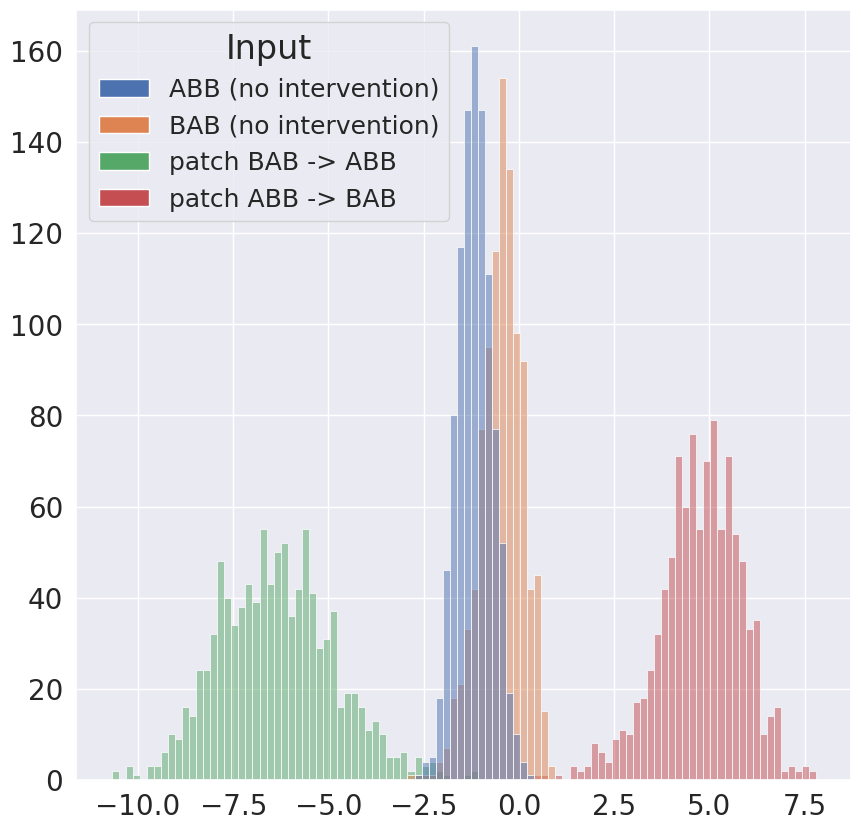

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# make a high-res plot
plt.figure(figsize=(10, 10))
ax = sns.histplot(
    data=df_mlp_out,
    x='value',
    hue='pattern',
    # do not stack, but overlap them
    # multiple='layer',
    bins=100,
    stat='count',
    # common_norm=False,
    element='bars',
    fill=True,
    # put the legend  in the upper left corner
    alpha=0.5,
)
# do the legend manually, using values from the "pattern" column
from matplotlib.patches import Patch
ax.legend(
    handles=[
        Patch(facecolor='C0', label='ABB (no intervention)'),
        Patch(facecolor='C1', label='BAB (no intervention)'),
        Patch(facecolor='C2', label='patch BAB -> ABB'),
        Patch(facecolor='C3', label='patch ABB -> BAB'),
    ],
    title='Input',
    title_fontsize=24,
    fontsize=18,
    loc='upper left',
    bbox_to_anchor=(0.0, 1.0),
    ncol=1,
)
# set the x-axis limits
# ax.set_xlim(-1.5, 3.0)
# ax.set_title('Output of MLP8 projected onto ground truth subspace')
# increase title font size
# remove the labels of the x and y axes
ax.set_xlabel(None)
ax.set_ylabel(None)
# increase font of the tikz on the axes
ax.tick_params(axis='both', which='major', labelsize=20)
# increase legend font size
# plt.setp(ax.get_legend().get_texts(), fontsize='30') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.savefig(f'figures/mlp_output_histograms.pdf', format='pdf')
plt.show()